# Frond ID Testing

Image processing workflow testing to identify approximate frond centers for subsequent machine transfer


In [1]:
import cv2
from plantcv import plantcv as pcv


In [2]:
class options:
    def __init__(self):
        self.image = "./img/petri.jpg"
        self.debug = "plot"
        self.writeimg= False
        self.result = "nir_tutorial_results.json"
        self.outdir = "." # Store the output to the current directory
        
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug


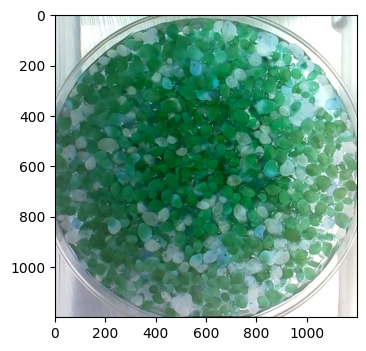

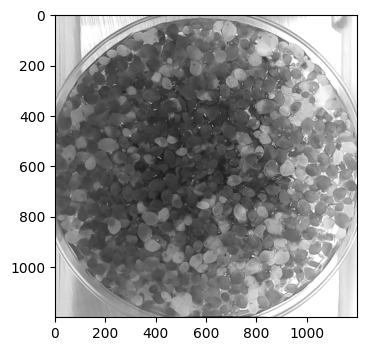

In [33]:
# Read image

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
rgb, path, filename = pcv.readimage(filename=args.image)
img = pcv.rgb2gray(rgb)


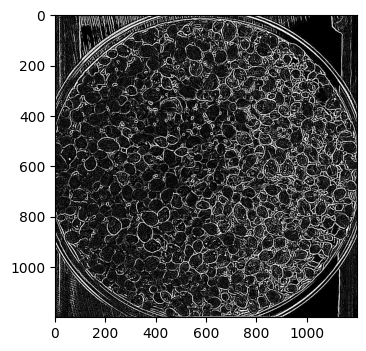

In [4]:
# Laplace filtering (identify edges based on 2nd derivative)

# Inputs:
#   gray_img - Grayscale image data 
#   ksize - Aperture size used to calculate the second derivative filter, 
#           specifies the size of the kernel (must be an odd integer)
#   scale - Scaling factor applied (multiplied) to computed Laplacian values 
#           (scale = 1 is unscaled) 
lp_img = pcv.laplace_filter(gray_img=img, ksize=5, scale=1)


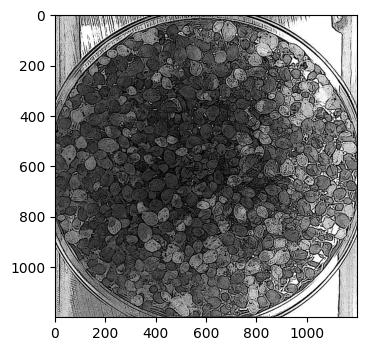

In [5]:
# Lapacian image sharpening, this step will enhance the darkness of the edges detected
lp_shrp_img = pcv.image_subtract(gray_img1=img, gray_img2=lp_img)


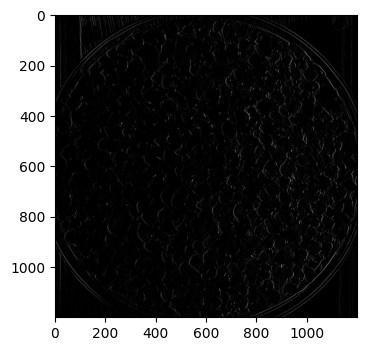

In [6]:
# Sobel filtering
# 1st derivative sobel filtering along horizontal axis, ksize = 1)

# Inputs: 
#   gray_img - Grayscale image data 
#   dx - Derivative of x to analyze 
#   dy - Derivative of y to analyze 
#   ksize - Aperture size used to calculate 2nd derivative, specifies the size of the kernel and must be an odd integer
# NOTE: Aperture size must be greater than the largest derivative (ksize > dx & ksize > dy) 
sbx_img = pcv.sobel_filter(gray_img=img, dx=1, dy=0, ksize=1)


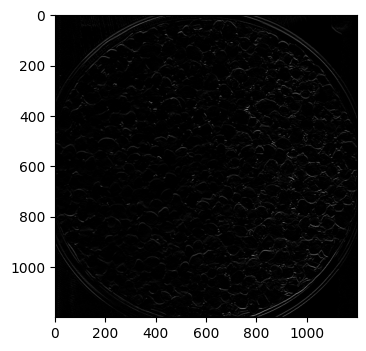

In [7]:
# 1st derivative sobel filtering along vertical axis, ksize = 1)

# Inputs:
#    gray_img - Grayscale image data
#    dx - derivative of x to analyze
#    dy - derivative of y to analyze 
#    ksize - apertures size used to calculate 2nd derivative filter, 
#    specifies the size of the kernel (must be an odd integer)
sby_img = pcv.sobel_filter(gray_img=img, dx=0, dy=1, ksize=1)


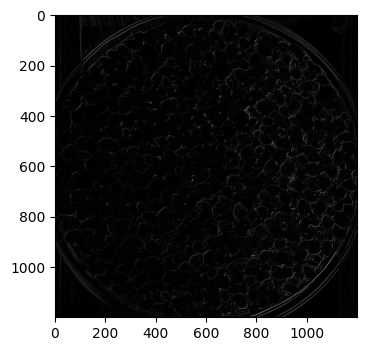

In [24]:
# Combine the effects of both x and y filters through matrix addition
# This will capture edges identified within each plane and emphasize edges found in both images

# Inputs:
#   gray_img1 - Grayscale image data to be added to gray_img2
#   gray_img2 - Grayscale image data to be added to gray_img1
sb_img = pcv.image_add(gray_img1=sbx_img, gray_img2=sby_img)


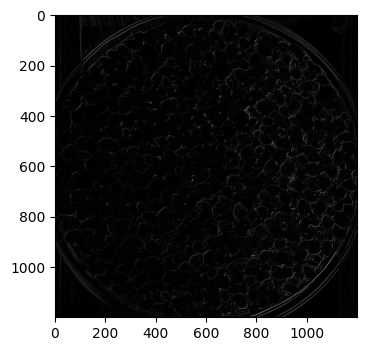

In [25]:
# Use a lowpass (blurring) filter to smooth sobel image

# Inputs:
#   gray_img - Grayscale image data 
#   ksize - Kernel size (integer or tuple), (ksize, ksize) box if integer input,
#           (n, m) box if tuple input 
mblur_img = pcv.median_blur(gray_img=sb_img, ksize=1)


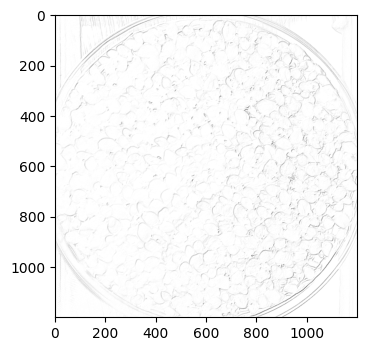

In [26]:
# Invert the image so our background is white 

# Inputs:
#   gray_img - Grayscale image data 
mblur_invert_img = pcv.invert(gray_img=mblur_img)


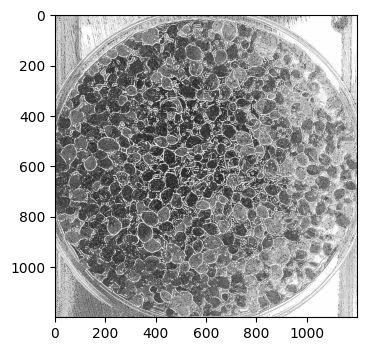

In [27]:
# Combine the smoothed sobel image with the laplacian sharpened image
# combines the best features of both methods as described in "Digital Image Processing" by Gonzalez and Woods pg. 169
edge_shrp_img = pcv.image_add(gray_img1=mblur_invert_img, gray_img2=lp_shrp_img)


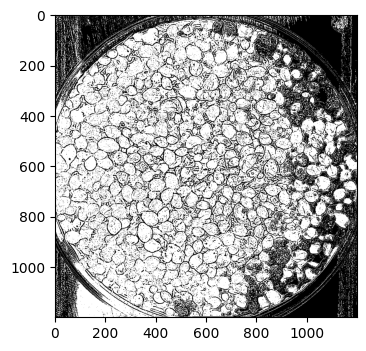

In [28]:
# Perform thresholding to generate a binary image

# Inputs: 
#   gray_img - Grayscale image data 
#   threshold - Threshold value (0-255)
#   max_value - Value to apply above the threshold (255 = white)
#   object_type - 'light' (default) or 'dark'. If the object is lighter than 
#                 the background then standard thresholding is done. If the 
#                 object is darker than the background then inverse thresholding. 
tr_es_img = pcv.threshold.binary(gray_img=edge_shrp_img, threshold=165, 
                                 max_value=255, object_type='dark')

# tr_es_img = pcv.threshold.otsu()


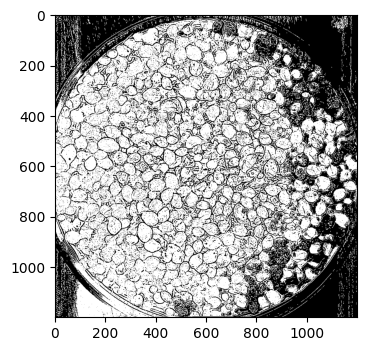

In [29]:
# Use the fill function to get rid of small salt & pepper noise in the image 

# Inputs: 
#   bin_img - Binary image data 
#   size - Minimum object area size in pixels (must be an integer), and smaller objects will be filled
f_img = pcv.fill(bin_img=tr_es_img, size=5)


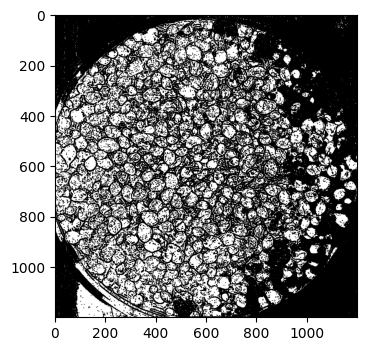

In [30]:
# There is another PlantCV function that can help reduce background 
# noise, and can be used with `pcv.dilate` to avoid losing plant 

# Inputs:
#   gray_img - Grayscale (usually binary) image data 
#   ksize - The size used to build a ksize x ksize 
#            matrix using np.ones. Must be greater than 1 to have an effect 
#   i - An integer for the number of iterations 
eroded_img = pcv.erode(gray_img=tr_es_img, ksize=3, i=1)


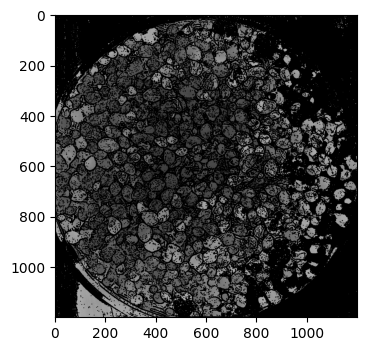

In [31]:
# Get masked image, Essentially identify pixels corresponding to plant and keep those.

# Inputs: 
#   img - RGB or grayscale image data 
#   mask - Binary mask image data 
#   mask_color - 'black' or 'white'
masked_erd = pcv.apply_mask(img=img, mask=eroded_img, mask_color='black')


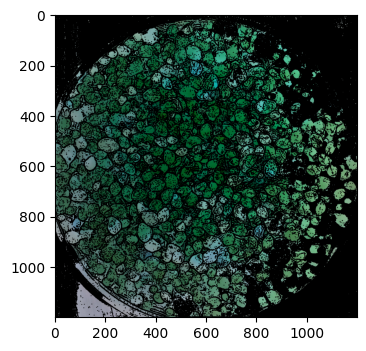

In [34]:
# get rgb image to get px values
masked_erd = pcv.apply_mask(img=rgb, mask=eroded_img, mask_color='black')


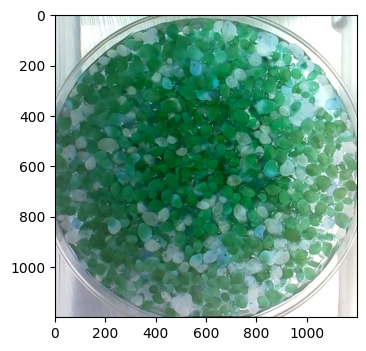

[[301, 324], [430, 723], [315, 610], [592, 323], [798, 561], [682, 317], [315, 498], [762, 406], [710, 679], [388, 313], [732, 516], [359, 451], [397, 531], [645, 793], [434, 601], [551, 598], [731, 788], [515, 727], [488, 484], [615, 413], [626, 578], [437, 431], [368, 378], [638, 503]]


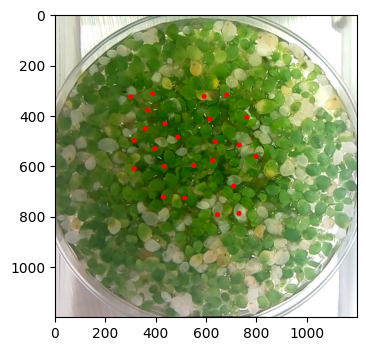

In [23]:
import random
from matplotlib import pyplot as plt
import math

def dist(x, y):
    a = (y[1] - x[1])**2
    b = (y[0] - x[0])**2
    return math.sqrt(a + b)

num_to_pick = 24
picked = []

for i in range(num_to_pick):
    pixel = None
    while pixel is None:
        rx = random.randint(300, 800)
        ry = random.randint(300, 800)
        pixel = masked_erd[ry, rx]
        # print(f"position is ({rx}, {ry})")

        if not pixel.all():
            pixel = None
            continue
        else:
            # make sure it's a certain dist away from other selected points
            minR = 50
            for p in picked:
                d = dist([rx, ry], p)
                # print(f"the distance is {d}")
                if d < minR:
                    # print('too close!')
                    pixel = None
                    break
            if pixel is not None:
                picked.append([rx, ry])
                
            
            


# draw a circle over the original image at that point
rgb, path, filename = pcv.readimage(filename=args.image)
print(picked)
for pt in picked:
    viz = cv2.circle(rgb, tuple(pt), 10, (255,0,0), -1)
plt.imshow(viz)
plt.show()
